#installing dependencies

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sun Sep 29 11:00:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-------

This notebook works fine with transformers 4.12, it is not tested on newer versions

In [38]:
!pip install -q -U transformers==4.12.2 torchmetrics
!pip install -q -U farasapy==0.0.14
!pip install -q -U pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install -q -U emoji==1.6.1
!pip install -q -U sentencepiece==0.1.96

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 12.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)
fatal: destination path 'arabert' already exists and is not an empty directory.


Let's download some Arabic text classification datasets

In [3]:
!git clone https://github.com/elnagara/HARD-Arabic-Dataset
!git clone https://github.com/mahmoudnabil/ASTD
!git clone https://github.com/nora-twairesh/AraSenti
!git clone https://github.com/mohamedadaly/LABR
!wget http://homepages.inf.ed.ac.uk/wmagdy/Resources/ArSAS.zip
!unzip ArSAS.zip
!unrar x '/content/HARD-Arabic-Dataset/data/unbalanced-reviews.rar'
!unzip '/content/HARD-Arabic-Dataset/data/balanced-reviews.zip'

Cloning into 'HARD-Arabic-Dataset'...
remote: Enumerating objects: 100, done.
remote: Total 100 (delta 0), reused 0 (delta 0), pack-reused 100 (from 1)
Receiving objects: 100% (100/100), 116.36 MiB | 24.02 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Cloning into 'ASTD'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29 (from 1)
Receiving objects: 100% (29/29), 558.04 KiB | 1.57 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Cloning into 'AraSenti'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20 (from 1)
Receiving objects: 100% (20/20), 1.69 MiB | 3.71 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Cloning into 'LABR'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37 (from 1)
Receiving objects: 100% (37/37), 12.32 MiB | 5.20 MiB/s, done.
Resolving deltas: 100% (12/12), done.
--2024-09-29 11:01:17--  http://homepa

#Creating training datasets

In [4]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

This custom dataset class will help us hold our datasets in a structred manner.
It's not necessary to use it with your own data

In [5]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [6]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

You can choose which ever dataset you like or use your own.
At this stage we don't do any preprocessing on the text, this is done later when loading the text.

##HARD - Balanced

In [7]:
df_HARD = pd.read_excel("/content/combine_claass_df_balnce.xlsx")
df_HARD.head()

,Unnamed: 0,text,label
0,0,وليد عبدالله العتيبي مستشفي عفيف العام شركه ا...,Computer Issues
1,1,تنبيه باخلاء المسءوليه هذه الرساله ومرفقاتها ...,Peripheral Device Issues
2,2,الاخوه الزملاء السلام عليكم ورحمه الله وبركاته...,Security Alerts
3,3,تنبيه باخلاء المسءوليه هذه الرساله ومرفقاتها ...,Uncategorized
4,4,تنبيه باخلاء المسءوليه هذه الرساله ومرفقاتها ...,Printer Issues


In [8]:
!pip install -q -U deep_translator fuzzywuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.6 MB/s eta 0:00:00


In [10]:
# from deep_translator import GoogleTranslator

# def translate_to_english(text):
#   """
#   Translates Arabic text to English using Google Translator.

#   Args:
#     text: The Arabic text to translate.

#   Returns:
#     The translated English text, or the original text if translation fails.
#   """
#   try:
#     translator = GoogleTranslator(source='ar', target='en')
#     translated_text = translator.translate(text)
#     return translated_text
#   except Exception as e:
#     print(f"Translation error: {e}")
#     return text


# # Apply the translation function to the 'Subject' column
# df_HARD['Subject_English'] = df_HARD['Subject'].apply(translate_to_english)

# # Print the updated DataFrame to verify the changes
# df_HARD[['Subject', 'Subject_English']].head()

In [11]:
# import pandas as pd
# from fuzzywuzzy import process

# # Updated class mapping with more keywords
# class_mapping = {
#     "Printer Issues": [
#         "printer", "paper jam", "laser jet", "open a printer",
#         "barcode printer", "printer not working", "printer failure"
#     ],
#     "Computer Issues": [
#         "computer", "device", "pc", "hardware",
#         "device screen", "computer malfunction", "computer not working"
#     ],
#     "Peripheral Device Issues": [
#         "keyboard", "mouse", "hard disk", "power supply", "usb",
#         "monitor", "display", "mouse malfunction", "keyboard malfunction"
#     ],
#     "Network Issues": [
#         "network", "internet", "access points", "extend network",
#         "network failure", "internet problem", "internet outage"
#     ],
#     "Maintenance Requests": [
#         "maintenance", "repair", "fix", "maintenance request",
#         "equipment maintenance", "device maintenance"
#     ],
#     "General Hardware Issues": [
#         "failure", "malfunction", "issue", "hardware failure",
#         "device issue", "system failure"
#     ],
#     "Security Alerts": [
#         "security alert", "urgent security", "security report",
#         "urgent report", "security issue"
#     ],
#     "Job Orders": [
#         "job - order", "job order", "task order", "job request"
#     ],
#     "Miscellaneous": [
#         "re:", "holidays", "scan", "hospital", "urgent",
#         "general inquiry", "request", "question", "help"
#     ]
# }

# # Function to classify subjects with fuzzy matching
# def classify_subject_fuzzy(subject, threshold=80):
#     subject = subject.lower()
#     for class_name, keywords in class_mapping.items():
#         match, score = process.extractOne(subject, keywords)
#         if score >= threshold:
#             return class_name
#     return "Uncategorized"

# # Applying the fuzzy classification function to the 'Subject_English' column
# df_HARD['Class'] = df_HARD['Subject_English'].apply(classify_subject_fuzzy)

# # Display the updated DataFrame
# df_HARD["Class"].value_counts()

In [12]:
# df_HARD["text"] = df_HARD["Request Detail"]+' '+df_HARD["Notes"]
# # df_HARD.to_excel("combine_claass_df.xlsx")
# df_HARD.head()

In [19]:
# prompt: this code under do not make the upasample balance well

import pandas as pd
from sklearn.utils import resample

# Identify the majority and minority classes
class_counts = df_HARD['Class'].value_counts()
majority_class = class_counts.idxmax()
minority_classes = class_counts[class_counts < class_counts.max()].index.tolist()

# Upsample the minority classes to match the majority class size
upsampled_dfs = []
for minority_class in minority_classes:
  minority_df = df_HARD[df_HARD['Class'] == minority_class]
  upsampled_df = resample(minority_df,
                          replace=True,  # Sample with replacement
                          n_samples=class_counts[majority_class],  # Match majority class size
                          random_state=42)  # Set a random seed for reproducibility
  upsampled_dfs.append(upsampled_df)

# Concatenate the upsampled minority class DataFrames with the original DataFrame
upsampled_df_HARD = pd.concat([df_HARD[df_HARD['Class'] == majority_class]] + upsampled_dfs)

# Verify the class distribution after upsampling
print(upsampled_df_HARD['Class'].value_counts())

# Now you can use `upsampled_df_HARD` for training your model
# You might want to shuffle the DataFrame after upsampling
upsampled_df_HARD = upsampled_df_HARD.sample(frac=1, random_state=42).reset_index(drop=True)
upsampled_df_HARD["Class"].value_counts()

Class
Printer Issues              268
Network Issues              268
Uncategorized               268
Computer Issues             268
Maintenance Requests        268
Miscellaneous               268
Peripheral Device Issues    268
Security Alerts             268
General Hardware Issues     268
Job Orders                  268
Name: count, dtype: int64


,count
Class,
Computer Issues,268
Peripheral Device Issues,268
Security Alerts,268
Uncategorized,268
Printer Issues,268
Job Orders,268
Network Issues,268
Miscellaneous,268
Maintenance Requests,268


In [13]:
df_HARD.drop(columns=["Unnamed: 0"], inplace=True)

In [15]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

# df_HARD = pd.read_excel("/content/combine_claass_df.xlsx")

# df_HARD = pd.read_csv("/content/balanced-reviews.txt", sep="\t", header=0,encoding='utf-16')

df_HARD = df_HARD[["text","label"]]  # we are interested in rating and review only
df_HARD.columns = [DATA_COLUMN, LABEL_COLUMN]
print(df_HARD[LABEL_COLUMN].value_counts())
# code rating as +ve if > 3, -ve if less, no 3s in dataset

hard_map = {
    "Printer Issues": "Printer Issues",
    "Computer Issues": "Computer Issues",
     "Peripheral Device Issues": "Peripheral Device Issues",
     "Network Issues": "Network Issues",
    'Maintenance Requests':'Maintenance Requests', # removed tab character from key
    "Uncategorized":"Uncategorized",
    "General Hardware Issues": "General Hardware Issues",
    "Security Alerts": "Security Alerts",
    "Job Orders": "Job Orders",
    "Miscellaneous": "Miscellaneous"
}


df_HARD[LABEL_COLUMN] = df_HARD[LABEL_COLUMN].apply(lambda x: hard_map[x])
train_HARD, test_HARD = train_test_split(df_HARD, test_size=0.2, random_state=42)
label_list_HARD = ["Computer Issues", "Peripheral Device Issues", "Security Alerts"	, "Uncategorized", "Printer Issues", "Job Orders"	, "Network Issues"	,"Miscellaneous","Maintenance Requests"	,
    "General Hardware Issues"	,
]

data_Hard = CustomDataset("HARD", train_HARD, test_HARD, label_list_HARD)
all_datasets.append(data_Hard)

label
Computer Issues             268
Peripheral Device Issues    268
Security Alerts             268
Uncategorized               268
Printer Issues              268
Job Orders                  268
Network Issues              268
Miscellaneous               268
Maintenance Requests        268
General Hardware Issues     268
Name: count, dtype: int64


In [29]:
upsampled_df_HARD.to_excel("combine_claass_df_balnce.xlsx")

#Trainer

Start the training procedure

In [16]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

List all the datasets we have

In [17]:
for x in all_datasets:
  print(x.name)

HARD


In [24]:
# select a dataset
dataset_name = 'HARD'
# select a model from the huggingface modelhub https://huggingface.co/models?language=ar
# model_name = 'aubmindlab/bert-base-arabertv02-twitter' # we are going to use the twitter AraBERT since it has emojis and dialects
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

# tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
# model_name = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-multilingual-cased")
model_name ="CAMeL-Lab/bert-base-arabic-camelbert-ca-poetry"

In [25]:
import copy
for d in all_datasets:
  if d.name==dataset_name:
    selected_dataset = copy.deepcopy(d)
    print('Dataset found')
    break

Dataset found


Create and apply preprocessing using the AraBERT processor

In [26]:
from arabert import ArabertPreprocessor

In [27]:
arabic_prep = ArabertPreprocessor(model_name)

selected_dataset.train[DATA_COLUMN] = selected_dataset.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
selected_dataset.test[DATA_COLUMN] = selected_dataset.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))

In [35]:
# Sanity check on the dataset
list(selected_dataset.train[DATA_COLUMN][0:10])

['ملاحظة التاريخ رسالة خاصة المؤلف عمر مختار النوع تقنية الوقت المعدل مرحبا عزيزي يسمح بالدخول إلى مواقع الويب هذه تأكد من الكتابة في المتصفح قبل عنوان إذا لم يعمل ، يرجى الاتصال ب مع تحياتي عمر عبد العزيز مختار ملاحظة الجوال ملاحظة التاريخ أنا المؤلف م عزت النوع تقنية الوقت المعدل مستشفى نافع لا يمكنه الدخول إلى مواقع الويب هذه إلى عمر ملاحظة',
 'ملاحظة التاريخ أنا المؤلف سارة البخيت النوع الفني الوقت المعدل تم تعيينه إلى ملاحظة التاريخ مساءا المؤلف باسل علي النوع الفني الوقت المعدل عزيزي روح الدرعية تحياتي لقد استبعدنا عنوان من خادم شكرا لك تحياتي باسل علي مهندس أمان الشبكات ملاحظة',
 'ملاحظة التاريخ رسالة خاصة المؤلف أوخضرة النوع فني الوقت المعدل المخصص للمهندس عبد الله ملاحظة ملاحظة التاريخ رسالة خاصة المؤلف أ فضل س س النوع فني الوقت المعدل عزيزي عبد العزيز لقد قمنا باستبدال المفتاح المعيب بمفتاح جديد من نفس الطراز منافذ سيسكو تحياتي عبد الله فضل س مهندس شبكات ملاحظة',
 'تنبيه باخلاء المسءوليه هذه الرساله ومرفقاتها معده لاستخدام المرسل اليه المقصود بالرساله فقط و قد تحتوي علي معلوم

Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [28]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/bert-base-arabic-camelbert-ca-poetry")
tok = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.05k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training Sentence Lengths: 


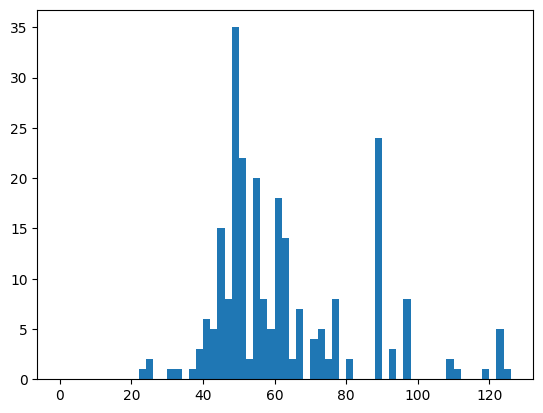

Testing Sentence Lengths: 


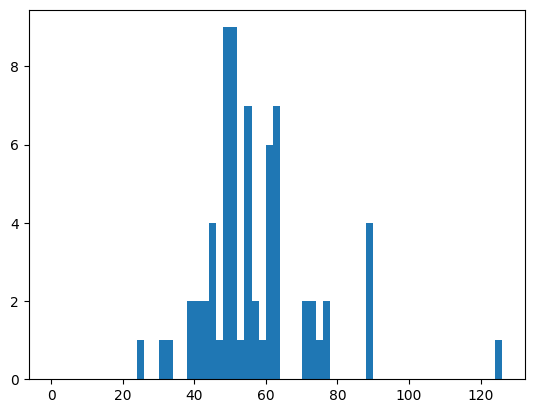

In [37]:
import matplotlib.pyplot as plt
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

Let's select 100 as our maximum sentence length, and check how many sequences will be truncated

In [29]:
max_len = 128

In [30]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))
print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  468
Truncated testing sequences:  468


8 out of ~4000 for testing isn't bad

Now let's create a classification dataset to load the data

In [31]:
from torch.utils.data import Dataset
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map


    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [32]:
label_map = { v:index for index, v in enumerate(selected_dataset.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    selected_dataset.train[DATA_COLUMN].to_list(),
    selected_dataset.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    selected_dataset.test[DATA_COLUMN].to_list(),
    selected_dataset.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'Computer Issues': 0, 'Peripheral Device Issues': 1, 'Security Alerts': 2, 'Uncategorized': 3, 'Printer Issues': 4, 'Job Orders': 5, 'Network Issues': 6, 'Miscellaneous': 7, 'Maintenance Requests': 8, 'General Hardware Issues': 9}


Check the dataset output

In [33]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer

class InputFeatures(object): # Add this class definition
    """A single set of features of data."""

    def __init__(self, input_ids, attention_mask, token_type_ids, label):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label = label

class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map


    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )
      return InputFeatures(**inputs,label=self.label_map[self.target[item]]) # Now this line should work

In [34]:
print(next(iter(train_dataset)))

Create a function that return a pretrained model ready to do classification

In [35]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map), ignore_mismatched_sizes=True)
    # Added ignore_mismatched_sizes=True to handle the mismatch in the number of labels.

Define whatever metric you want here

In [45]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 17.3 MB/s eta 0:00:00


In [36]:
n_classes = len(label_map)

In [ ]:
# from torchmetrics import F1Score
# def compute_metrics(p): #p should be of type EvalPrediction
#   preds = np.argmax(p.predictions, axis=1)
#   assert len(preds) == len(p.label_ids)
#   #print(classification_report(p.label_ids,preds))
#   #print(confusion_matrix(p.label_ids,preds))
#   f1_score = F1Score(task="multiclass", num_classes=n_classes, average='macro') # Create an F1Score instance with the 'multiclass' task
#   macro_f1 = f1_score(preds, p.label_ids) # Calculate the F1 score by passing the predictions and labels and store it in a variable
#   # macro_f1 = F1Score(p.label_ids,preds,average='macro')
#   #macro_precision = precision_score(p.label_ids,preds,average='macro')
#   #macro_recall = recall_score(p.label_ids,preds,average='macro')
#   acc = accuracy_score(p.label_ids,preds)
#   return {
#       'macro_f1' : macro_f1,
#       'accuracy': acc
#   }
#   # "CAMeL-Lab/bert-base-arabic-camelbert-ca-poetry"

In [37]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

#Regular Training

Define our training parameters.
Check the TrainingArguments documentation for more options https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [40]:
from transformers import TrainingArguments, Trainer
import random
training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = True, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 10,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer

In [42]:
!pip install torchmetrics
# !pip install --upgrade torch

from transformers import AutoModelForSequenceClassification
import torch
from torchmetrics import F1Score, Precision, Recall, Accuracy

# Convert NumPy arrays to PyTorch tensors and calculate metrics
def compute_metrics(p):
  preds = torch.from_numpy(p.predictions)
  labels = torch.from_numpy(p.label_ids)
  preds = torch.argmax(preds, axis=1)

  f1_score = F1Score(task="multiclass", num_classes=n_classes, average='macro')
  macro_f1 = f1_score(preds, labels)

  precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
  macro_precision = precision(preds, labels)

  recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
  macro_recall = recall(preds, labels)

  accuracy = Accuracy(task="multiclass", num_classes=n_classes)
  acc = accuracy(preds, labels)

  return {'macro_f1' : macro_f1, 'macro_precision': macro_precision, 'macro_recall': macro_recall, 'accuracy': acc}

trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

  Using cached torchmetrics-1.4.2-py3-none-any.whl.metadata (19 kB)
  Using cached lightning_utilities-0.11.7-py3-none-any.whl.metadata (5.2 kB)
Using cached torchmetrics-1.4.2-py3-none-any.whl (869 kB)
Using cached lightning_utilities-0.11.7-py3-none-any.whl (26 kB)


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-poetry and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([23, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([23]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
1,No log,2.529585,0.016123,0.008769,0.100000,0.087687
2,No log,2.641871,0.018305,0.010075,0.100000,0.100746
3,No log,2.577691,0.017376,0.009515,0.100000,0.095149
4,No log,2.414201,0.019224,0.010634,0.100000,0.106343
5,No log,2.436615,0.019224,0.010634,0.100000,0.106343
6,No log,2.353942,0.015808,0.008582,0.100000,0.085821
7,No log,2.360803,0.020134,0.011194,0.100000,0.111940
8,2.492600,2.370004,0.017997,0.009888,0.100000,0.098881
9,2.492600,2.374322,0.020134,0.011194,0.100000,0.111940
10,2.492600,2.310212,0.017376,0.009515,0.100000,0.095149


TrainOutput(global_step=670, training_loss=2.4584684001865673, metrics={'train_runtime': 288.0362, 'train_samples_per_second': 74.435, 'train_steps_per_second': 2.326, 'total_flos': 1410376555069440.0, 'train_loss': 2.4584684001865673, 'epoch': 10.0})

Save the model, the tokenizer and the config

In [50]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

{0: 'Computer Issues', 1: 'Peripheral Device Issues', 2: 'Security Alerts', 3: 'Uncategorized', 4: 'Printer Issues', 5: 'Job Orders', 6: 'Network Issues', 7: 'Miscellaneous', 8: 'Maintenance Requests', 9: 'General Hardware Issues'}


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json',
 'output_dir/tokenizer.json')

In [ ]:
#copy the model to drive
!cp output_dir /content/drive/MyDrive

cp: -r not specified; omitting directory 'output_dir'


## predict using the saved model

In [51]:
from transformers import pipeline

In [52]:
# initialize pipline
pipe = pipeline("text-classification", model="output_dir", device=0, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [53]:
pipe("نفيد سعادتكم بوجود مشكله جهاز عياده العظام الدخول وفتح الجهاز بيوزر موظف نوع الجهاز رقم الجهاز برجاء الاطلاع وتوجيه المختصين ليدكم لحل المشكله ولكم جزيل الشكر مدير تقنيه المعلومات بمستشفي السليل العام منصور عبدالله الحابي تنبيه باخلاء المسءوليه ومرفقاتها معده لاستخدام اليه بالرساله فقط تحتوي سريه محميه قانونيا تكن الشخص فانه يمنع منعا باتا عرض نشر استخدام مصرح للمحتوي اخطار الالكتروني واتلاف النسخ الموجوده لديك تعد التصريحات الاراء بالمرسل تمثل تتحمل مسءوليه الاضرار الناتجه فيروسات تحملها")

[[{'label': 'Computer Issues', 'score': 0.14079122245311737},
  {'label': 'Peripheral Device Issues', 'score': 0.004707982297986746},
  {'label': 'Security Alerts', 'score': 0.019273553043603897},
  {'label': 'Uncategorized', 'score': 0.05770004913210869},
  {'label': 'Printer Issues', 'score': 0.05498286709189415},
  {'label': 'Job Orders', 'score': 0.006223469041287899},
  {'label': 'Network Issues', 'score': 0.014804959297180176},
  {'label': 'Miscellaneous', 'score': 0.10969039797782898},
  {'label': 'Maintenance Requests', 'score': 0.5517280697822571},
  {'label': 'General Hardware Issues', 'score': 0.040097422897815704}]]

# K-fold

This section is bit more advanced.

We will divide the training set into K-folds and train model with cross-validation to check for the best hyper-parameters before check the performance on the test set.

Alternatively, you can combine the training and testing set if you are participating in a competition, then ensemble the output models

In [54]:
# do kfold on the training. Check the perfomance on the test set
kfold_dataset = selected_dataset.train
# do kfold on all the dataset. Here we will not have any dataset to checl final performance on (this is used mainly in competitions)
# kfold_dataset = pd.concat([selected_dataset.train,selected_dataset.test])
kfold_dataset.reset_index(inplace=True,drop=True)

In [55]:
# this is used later
inv_label_map = { v:k for k, v in label_map.items()}

Defing the number of Stratified kfold splits

In [56]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=123
  )

Train using cross validation and save the best model at each fold

In [57]:
all_results = []
fold_best_f1 = 0
best_fold = None
for fold_num , (train, dev) in enumerate(kf.split(kfold_dataset,kfold_dataset['label'])):
  print("**************************Starting Fold Num: ", fold_num," **************************")

  train_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][train]),
                              list(kfold_dataset[LABEL_COLUMN][train]),
                              model_name,
                              max_len,
                              label_map)

  val_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][dev]),
                              list(kfold_dataset[LABEL_COLUMN][dev]),
                              model_name,
                              max_len,
                              label_map)

  training_args = TrainingArguments(
    output_dir= f"./train_{fold_num}",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2,
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 123
  )

  set_seed(training_args.seed)

  trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  )
  trainer.model.config.label2id = label_map
  trainer.model.config.id2label = inv_label_map

  trainer.train()

  results = trainer.evaluate()
  all_results.append(results)
  print(results)

  trainer.save_model(f"./train_{fold_num}/best_model")
  val_dataset.tokenizer.save_pretrained(f"./train_{fold_num}/best_model")

  # delete the rest of the checkpoints
  !rm -rf f"./train_{fold_num}/checkpoint-*"

  if results['eval_macro_f1'] > fold_best_f1:
    print('**************************New Best Model Found!**************************')
    fold_best_f1 = results['eval_macro_f1']
    best_fold = fold_num

**************************Starting Fold Num:  0  **************************


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
0,No log,2.190735,0.174119,0.148741,0.238122,0.240093
1,No log,2.124217,0.199679,0.235990,0.279518,0.279720


{'eval_loss': 2.1242172718048096, 'eval_macro_f1': 0.19967903196811676, 'eval_macro_precision': 0.2359902262687683, 'eval_macro_recall': 0.27951812744140625, 'eval_accuracy': 0.279720276594162, 'eval_runtime': 3.0734, 'eval_samples_per_second': 139.587, 'eval_steps_per_second': 1.302, 'epoch': 1.925925925925926}
**************************New Best Model Found!**************************
**************************Starting Fold Num:  1  **************************


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
0,No log,2.173897,0.203112,0.287883,0.289729,0.289044
1,No log,2.095217,0.278172,0.311964,0.325871,0.326340


{'eval_loss': 2.0952165126800537, 'eval_macro_f1': 0.2781718075275421, 'eval_macro_precision': 0.3119640052318573, 'eval_macro_recall': 0.3258708715438843, 'eval_accuracy': 0.32634031772613525, 'eval_runtime': 3.2798, 'eval_samples_per_second': 130.802, 'eval_steps_per_second': 1.22, 'epoch': 1.925925925925926}
**************************New Best Model Found!**************************
**************************Starting Fold Num:  2  **************************


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
0,No log,2.176960,0.187885,0.243367,0.223125,0.223776
1,No log,2.105450,0.250940,0.245727,0.288631,0.289044


{'eval_loss': 2.105449914932251, 'eval_macro_f1': 0.25093987584114075, 'eval_macro_precision': 0.2457273155450821, 'eval_macro_recall': 0.2886313199996948, 'eval_accuracy': 0.2890442907810211, 'eval_runtime': 3.1365, 'eval_samples_per_second': 136.778, 'eval_steps_per_second': 1.275, 'epoch': 1.925925925925926}
**************************Starting Fold Num:  3  **************************


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
0,No log,2.159365,0.184121,0.164455,0.251994,0.256410
1,No log,2.102549,0.206892,0.236981,0.256473,0.258741


{'eval_loss': 2.102548837661743, 'eval_macro_f1': 0.20689156651496887, 'eval_macro_precision': 0.23698142170906067, 'eval_macro_recall': 0.2564725875854492, 'eval_accuracy': 0.25874125957489014, 'eval_runtime': 3.3254, 'eval_samples_per_second': 129.008, 'eval_steps_per_second': 1.203, 'epoch': 1.925925925925926}
**************************Starting Fold Num:  4  **************************


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
0,No log,2.166115,0.182816,0.179094,0.245838,0.247664
1,No log,2.102832,0.221716,0.207426,0.290054,0.289720


{'eval_loss': 2.102832317352295, 'eval_macro_f1': 0.22171643376350403, 'eval_macro_precision': 0.2074260115623474, 'eval_macro_recall': 0.29005420207977295, 'eval_accuracy': 0.2897196114063263, 'eval_runtime': 3.2318, 'eval_samples_per_second': 132.435, 'eval_steps_per_second': 1.238, 'epoch': 1.925925925925926}


In [58]:
# prompt: make visulization using ployly express for all_results

import plotly.express as px

# Extract the relevant metrics from all_results
eval_macro_f1_scores = [result['eval_macro_f1'] for result in all_results]
eval_accuracy_scores = [result['eval_accuracy'] for result in all_results]
eval_macro_precision_scores = [result['eval_macro_precision'] for result in all_results]
eval_macro_recall_scores = [result['eval_macro_recall'] for result in all_results]
fold_numbers = list(range(len(all_results)))


# Create a DataFrame for the visualization
df_results = pd.DataFrame({
    'Fold': fold_numbers,
    'Macro F1': eval_macro_f1_scores,
    'Accuracy': eval_accuracy_scores,
    'Macro Precision': eval_macro_precision_scores,
    'Macro Recall': eval_macro_recall_scores
})

# Create a line plot using Plotly Express
fig = px.line(df_results, x='Fold', y=['Macro F1', 'Accuracy', 'Macro Precision', 'Macro Recall'],
              title='Cross-Validation Performance Across Folds')
fig.update_layout(xaxis_title='Fold Number', yaxis_title='Metric Score')
fig.show()


In [59]:
all_results

[{'eval_loss': 2.1242172718048096,
  'eval_macro_f1': 0.19967903196811676,
  'eval_macro_precision': 0.2359902262687683,
  'eval_macro_recall': 0.27951812744140625,
  'eval_accuracy': 0.279720276594162,
  'eval_runtime': 3.0734,
  'eval_samples_per_second': 139.587,
  'eval_steps_per_second': 1.302,
  'epoch': 1.925925925925926},
 {'eval_loss': 2.0952165126800537,
  'eval_macro_f1': 0.2781718075275421,
  'eval_macro_precision': 0.3119640052318573,
  'eval_macro_recall': 0.3258708715438843,
  'eval_accuracy': 0.32634031772613525,
  'eval_runtime': 3.2798,
  'eval_samples_per_second': 130.802,
  'eval_steps_per_second': 1.22,
  'epoch': 1.925925925925926},
 {'eval_loss': 2.105449914932251,
  'eval_macro_f1': 0.25093987584114075,
  'eval_macro_precision': 0.2457273155450821,
  'eval_macro_recall': 0.2886313199996948,
  'eval_accuracy': 0.2890442907810211,
  'eval_runtime': 3.1365,
  'eval_samples_per_second': 136.778,
  'eval_steps_per_second': 1.275,
  'epoch': 1.925925925925926},
 {'eva

In [60]:
from statistics import mean
mean([x['eval_macro_f1'] for x in all_results])

0.2314797431230545

After checking for the best hyper parameters you should use the regular training section and retrain the model with the parameters that you had here.

Or Ensemble the models together.

## Ensemble all the cross validation models

In [61]:
from transformers import pipeline
import more_itertools

In [62]:
inv_label_map = { v:k for k, v in label_map.items()}

Load some file which has text that we need to run inference on.
I will use the test set for that

In [63]:
# pred_df = prediction['Text']
# pred_df = pred_df.apply(lambda x:   arabic_prep.preprocess(x))

pred_df = selected_dataset.test[DATA_COLUMN]

In [64]:
cross_val_df = pd.DataFrame([])
for i in range(0,5):
  pipe = pipeline("text-classification", model=f"train_{i}/best_model", device=0, return_all_scores =True, max_length=max_len, truncation=True)
  preds = []
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference
    preds.extend(pipe(s))
  cross_val_df[f'model_{i}'] = preds

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

<ipython-input-64-b42f74aaeb31>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

<ipython-input-64-b42f74aaeb31>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

<ipython-input-64-b42f74aaeb31>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

<ipython-input-64-b42f74aaeb31>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.

<ipython-input-64-b42f74aaeb31>:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

In [65]:
from collections import defaultdict

final_labels = []
final_scores = []
for id, row in cross_val_df.iterrows():
  total_score = defaultdict(lambda: 0)
  for pred in row:
    for cls in pred:
      total_score[cls['label']] += cls['score']

  avg_score = { k: v/ 5 for k, v in total_score.items()}

  final_labels.append(max(avg_score, key=avg_score.get))
  final_scores.append(avg_score[max(avg_score, key=avg_score.get)])

In [66]:
cross_val_df['preds'] = final_labels
cross_val_df['class'] = final_scores

In [67]:
cross_val_df['preds'].value_counts()

,count
preds,
Computer Issues,148
Maintenance Requests,112
Job Orders,101
Security Alerts,68
Peripheral Device Issues,59
Miscellaneous,15
General Hardware Issues,14
Network Issues,11
Printer Issues,5


In [68]:
from sklearn.metrics import classification_report

In [69]:
print(classification_repfrom sklearn.metrics import classification_reportort(selected_dataset.test[LABEL_COLUMN],cross_val_df['preds']))

                          precision    recall  f1-score   support

         Computer Issues       0.22      0.70      0.34        47
 General Hardware Issues       0.21      0.05      0.08        57
              Job Orders       0.42      0.82      0.55        51
    Maintenance Requests       0.09      0.19      0.12        53
           Miscellaneous       0.33      0.09      0.14        54
          Network Issues       0.45      0.09      0.15        57
Peripheral Device Issues       0.34      0.43      0.38        46
          Printer Issues       0.00      0.00      0.00        60
         Security Alerts       0.49      0.55      0.52        60
           Uncategorized       0.00      0.00      0.00        51

                accuracy                           0.28       536
               macro avg       0.26      0.29      0.23       536
            weighted avg       0.26      0.28      0.22       536



In [73]:
!pip install -q -U rouge_score sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.6 MB/s eta 0:00:00


In [74]:
from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU

def calculate_rouge_and_bleu(predictions, references):
    """Calculates ROUGE and BLEU scores for a list of predictions and references.

    Args:
        predictions: A list of predicted strings.
        references: A list of reference strings.
    """

    # Initialize the scorers
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    bleu_scorer = BLEU(effective_order=True)

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    bleu_scores = []

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calculate BLEU score once for the entire corpus, not individually
    bleu_score = bleu_scorer.corpus_score(predictions, [references]).score

    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

    return avg_rouge1, avg_rouge2, avg_rougeL, bleu_score

# Replace 'selected_dataset.test[DATA_COLUMN]' with your actual predictions and 'selected_dataset.test[LABEL_COLUMN]' with your true labels.
predictions = cross_val_df['preds'].tolist()
references = selected_dataset.test[LABEL_COLUMN].tolist()

# Ensure predictions and references are strings
predictions = [str(p) for p in predictions]
references = [str(r) for r in references]

avg_rouge1, avg_rouge2, avg_rougeL, avg_bleu = calculate_rouge_and_bleu(predictions, references)

print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")
print(f"Average BLEU: {avg_bleu}")

Average ROUGE-1: 0.3407960199004978
Average ROUGE-2: 0.27238805970149255
Average ROUGE-L: 0.3407960199004978
Average BLEU: 31.527445493928596


In [ ]:
from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU

def calculate_rouge_and_bleu(predictions, references):
    """Calculates ROUGE and BLEU scores for a list of predictions and references.

    Args:
        predictions: A list of predicted strings.
        references: A list of reference strings.
    """

    # Initialize the scorers
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    bleu_scorer = BLEU(effective_order=True)

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    bleu_scores = []

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calculate BLEU score once for the entire corpus, not individually
    bleu_score = bleu_scorer.corpus_score(predictions, [references]).score

    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

    return avg_rouge1, avg_rouge2, avg_rougeL, bleu_score

# Replace 'selected_dataset.test[DATA_COLUMN]' with your actual predictions and 'selected_dataset.test[LABEL_COLUMN]' with your true labels.
predictions = cross_val_df['preds'].tolist()
references = selected_dataset.test[LABEL_COLUMN].tolist()

# Ensure predictions and references are strings
predictions = [str(p) for p in predictions]
references = [str(r) for r in references]

avg_rouge1, avg_rouge2, avg_rougeL, avg_bleu = calculate_rouge_and_bleu(predictions, references)

print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")
print(f"Average BLEU: {avg_bleu}")

Average ROUGE-1: 0.6515463917525773
Average ROUGE-2: 0.6391752577319587
Average ROUGE-L: 0.6515463917525773
Average BLEU: 71.91311572088277
